In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Defining Transforms

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        # Requirements for pretrained models:
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        # Requirements for pretrained models:
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, label_file, class_names, class_to_idx, transform):
        self.root_dir = root_dir
        self.label_file = label_file
        self.class_names = class_names
        self.class_to_idx = class_to_idx
        self.transform = transform

        # Read the labels from the Excel file
        self.labels = pd.read_excel(label_file, usecols=[3], names=['smiling'])['smiling'].tolist()

        # Get the list of image files (without the lambda it was not in order)
        self.image_files = []
        for root, dirs, files in os.walk(root_dir): 
            self.image_files.extend([os.path.join(root, file) for file in sorted(files, key=lambda x: int(''.join(filter(str.isdigit, x))))])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and apply the transformation
        image = Image.open(self.image_files[idx])
        if self.transform:
            image = self.transform(image)

        # Convert the label to a tensor
        label = torch.tensor(self.labels[idx])
        
        return image, label

# Define the root directory of the dataset and the label file
root_dir = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\celeba\img'
label_file = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\celeba\labels.xlsx'
root_dir_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\celeba_test\img'
label_file_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\celeba_test\labels.xlsx'

# Define the class names and their corresponding indexes
class_names = ['Smile', 'NoSmile']
class_to_idx = {'Smile': 1, 'NoSmile': -1}

train_data = MyDataset(root_dir, label_file, class_names, class_to_idx, transform=train_transform)
test_data = MyDataset(root_dir_test, label_file_test, class_names, class_to_idx, transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')



['Smile', 'NoSmile']
Training images available: 5000
Testing images available:  1000


# Using pre trained model

In [4]:
RegnetY16GF = models.regnet_y_16gf(weights=models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1)
RegnetY16GF

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [5]:
# Freezing parameters
for param in RegnetY16GF.parameters():
    param.requires_grad = False
  
# modifying classifier
torch.manual_seed(42)

RegnetY16GF.fc = nn.Sequential(nn.Linear(3024,1000),nn.Linear(1000,2),nn.LogSoftmax(dim=1))

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RegnetY16GF.fc.parameters(), lr=0.001)

for param in RegnetY16GF.fc.parameters():
    param.requires_grad = True




In [6]:
RegnetY16GF.fc



Sequential(
  (0): Linear(in_features=3024, out_features=1000, bias=True)
  (1): Linear(in_features=1000, out_features=2, bias=True)
  (2): LogSoftmax(dim=1)
)

In [7]:
import time
start_time = time.time()

epochs = 10

max_trn_batch = 156 # 156 * 32 = 4992
max_tst_batch = 31 # 31 * 32 = 992

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
        
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Changing the labels to be in the range [0, num_classes-1].
        y_train = torch.where(y_train == 1, torch.tensor(1), torch.tensor(0))


        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = RegnetY16GF(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%(max_trn_batch/2) == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{32*b:4}/4992]  loss: {loss.item():10.8f}  |  accuracy: {trn_corr.item()*100/(32*b):7.2f}%   |   Duration: {time.time() - start_time:.0f} seconds')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Changing the labels to be in the range [0, num_classes-1].
            y_test = torch.where(y_test == 1, torch.tensor(1), torch.tensor(0))

            # Apply the model
            y_val = RegnetY16GF(X_test)
            loss = criterion(y_val, y_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   78 [2496/4992]  loss: 0.57563508  |  accuracy:   68.55%   |   Duration: 1244 seconds
epoch:  0  batch:  156 [4992/4992]  loss: 0.46963006  |  accuracy:   73.02%   |   Duration: 2498 seconds
epoch:  1  batch:   78 [2496/4992]  loss: 0.36063030  |  accuracy:   79.57%   |   Duration: 4227 seconds
epoch:  1  batch:  156 [4992/4992]  loss: 0.36693367  |  accuracy:   80.51%   |   Duration: 5484 seconds
epoch:  2  batch:   78 [2496/4992]  loss: 0.31988102  |  accuracy:   82.33%   |   Duration: 7241 seconds
epoch:  2  batch:  156 [4992/4992]  loss: 0.58515298  |  accuracy:   82.31%   |   Duration: 8467 seconds
epoch:  3  batch:   78 [2496/4992]  loss: 1.08304155  |  accuracy:   81.89%   |   Duration: 10211 seconds
epoch:  3  batch:  156 [4992/4992]  loss: 0.30198464  |  accuracy:   81.77%   |   Duration: 11455 seconds
epoch:  4  batch:   78 [2496/4992]  loss: 0.39719313  |  accuracy:   83.69%   |   Duration: 13195 seconds
epoch:  4  batch:  156 [4992/4992]  loss: 0.30342484

In [8]:
torch.save(RegnetY16GF.state_dict(), 'A2RegnetY16GFModel.pt')

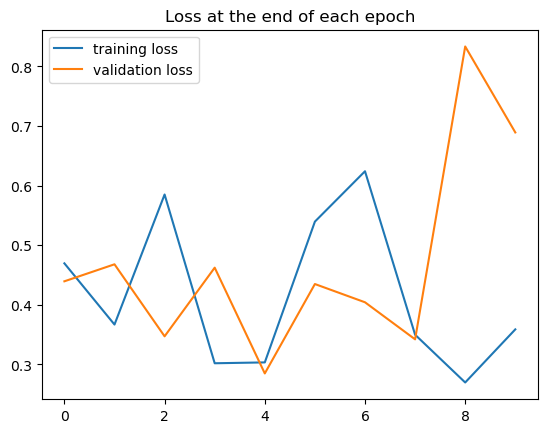

In [9]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

[808, 799, 748, 805, 814, 808, 781, 823, 837, 734]
Test accuracy: 73.992%


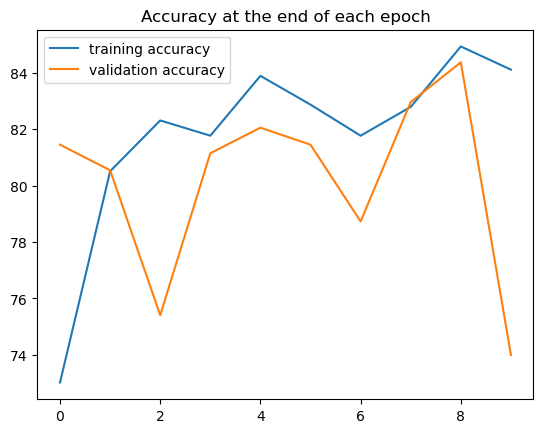

In [10]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1]*100/992:.3f}%')

plt.plot([t/49.92 for t in train_correct], label='training accuracy')
plt.plot([t/9.92 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();